# 들어가며

**실습 목표**

- 추천 시스템의 개념과 목적 이해
- Implicit library를 활용하여 Matrix Factorization 기반의 추천 모델을 만들어본다.
- 음악 감상 기록을 활용하여 비슷한 아티스트를 찾고 아티스트를 추천해 본다.
- 추천 시스템에서 자주 사용되는 데이터 구조인 CSR Matrix을 익힌다
- 유저의 행위 데이터 중 Explicit data와 Implicit data의 차이점을 익힌다.
- 새로운 데이터셋으로 직접 추천 모델을 만들어 본다.

**목차**

- 추천 시스템이란 게 뭔가요?
- 데이터 탐색하기와 전처리
- 사용자의 명시적/암묵적 평가
- Matrix Factorization(MF)
- CSR(Compressed Sparse Row) Matrix
- MF 모델 학습하기
- 비슷한 아티스트 찾기 + 유저에게 추천하기
- 프로젝트 - MovieLens 영화 추천 실습

# 추천 시스템이란?

[추천의 원리](http://www.kocca.kr/insight/vol05/vol05_04.pdf)를 알아보자.

## 협업 필터링 vs 콘텐츠 기반 필터링

협업 필터링은 다수의 사용자의 아이템 구매 이력 정보만으로 사용자간 유사성 및 아이템 간 유사성을 파악하지만,

콘텐츠 기반 필터링은 아이템의 고유의 정보를 바탕으로 아이템 간 유사성을 파악합니다.

다시 말해, 협업 필터링에서는 아이템과 사용자 간의 행동 또는 관계에만 주목할 뿐 아이템 자체의 고유한 속성에 주목하지 않습니다.

콘텐츠 기반 필터링에서는 아이템 자체의 속성에만 주목하고 사용자와 아이템 간의 관련성 에는 주목하지 않습니다.

## 추천시스템의 핵심 근간은 협업 필터링이다. 이를 바로 사용할 수 없는 제약 조건 3가지

- 시스템이 충분한 정보를 모으지 못한 사용자나 아이템에 대한 추론을 할 수 없는 상태인 콜드 스타트(Cold Start) 상황

- 계산량이 너무 많아 추천의 효율이 떨어지는 상황

- 롱테일의 꼬리 부분, 즉 사용자의 관심이 저조한 항목의 정보가 부족하여 추천에서 배제되는 상황

이렇게 추천 시스템은 `아이템이 매우 많고`, `유저의 취향이 다양할 때` 유저가 소비할 만한 아이템을 예측하는 모델이다.
```python
$ mkdir -p ~/aiffel/recommendata_iu/data/lastfm-dataset-360K
$ ln -s ~/data/lastfm-dataset-360K/* ~/aiffel/recommendata_iu/data/lastfm-dataset-360K

```

# 데이터 탐색하기와 전처리

## 데이터 준비

항목을 열어보면, `user-mboxsha1 \t musicbrainz-artist-id \t artist-name \t plays` 이렇게 4가지가 보일 것이다. 이들은 각각, `User ID, Artist MBID, Artist Name, Play횟수`로 보인다.

Pandas를 이용해 데이터를 열어보자. 컬럼명을 적절히 지정해주자.

In [44]:
import pandas as pd
import os

fname = os.getenv('HOME') + '/aiffel/recommendata_iu/data/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
data.head(10)

,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


artist_MBID 항목은 우리의 관심사가 아니다. 사용하는 컬럼만 남기고 제거하도록 하자.

In [45]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [46]:
 # 검색을 쉽게 하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data['artist'] = data['artist'].str.lower()
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


첫 번째 유저가 어떤 아티스트의 노래를 듣는지 확인해보자.

In [5]:
condition = (data['user_id']== data.loc[0, 'user_id'])
data.loc[condition]

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


모르는 아티스트가 많다. 추천 시스템에서는 적용 분야에 대한 지식이 특히 더 중요한데, 모르면 검증을 못 하기 때문이다.

## 데이터 탐색

추천모델을 만들기 전에 데이터의 기본적인 정보를 보고 가자.

- 유저 수, 아티스트 수, 인기 많은 아티스트
- 유저들이 몇 명의 아티스트를 듣고 있는지에 대한 통계
- 유저 play 횟수 중앙값에 대한 통계

(참고) pandas.DataFrame.nunique()은 특정 컬럼에 포함된 유니크한 데이터의 개수를 알아보는데 유용하다.

In [58]:
# 유저 수
data['user_id'].nunique()

358869

In [59]:
# 아티스트 수
data['artist'].nunique()

291347

In [60]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
217     77254
247     76245
62      66659
5       48924
277     46954
283     45233
268     44443
28      41229
352     39773
910     39479
193     37267
75      34174
418     33206
1170    33001
776     32624
279     32295
473     32072
531     31916
780     31862
1092    31799
96      31482
55      30348
694     30144
201     29795
41      29754
773     28946
243     28901
503     28732
203     28691
615     28232
Name: user_id, dtype: int64

In [61]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358869.000000
mean         48.863680
std           8.524494
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [62]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358869.000000
mean        142.187364
std         213.089688
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

## 모델 검증을 위한 사용자 초기 정보 세팅

우리가 만든 추천 시스템의 추후 검증을 위해, 내가 무엇을 좋아하는지 위 데이터셋에 5개 이상 추가해주어야 한다.

In [63]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['zimin']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['zimin']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30
4,358868,396,30
0,zimin,black eyed peas,30
1,zimin,maroon5,30
2,zimin,jason mraz,30
3,zimin,coldplay,30
4,zimin,beyoncé,30


## 모델을 활용하기 위한 전처리(실습)

데이터 관리를 용이하게 하기 위해 번호를 붙여주자.(indexing 작업)

(참고) pandas.DataFrame.unique()은 특정 컬럼에 포함된 유니크한 데이터만 모아 줍니다. indexing 작업을 위해 매우 유용하다.

In [64]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [65]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['zimin'])    # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 합니다. 
print(artist_to_idx['black eyed peas'])

358869
291347


In [66]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358869,291347,30
1,358869,291348,30
2,358869,291349,30
3,358869,291350,30


전처리가 완료되었다.

# 사용자의 명시적/암묵적 평가

이 추천 시스템은 사용자들이 얼마나 아이템을 선호하는지를 모델링하기를 원한다. 그러기 위해서는 `사용자의 아이템 선호도를 말해주는 유저 행동 데이터셋`이 필요하다. 서비스를 이용하면서 자연스럽게 발생하는 implicit한 피드백도 사용자의 아이템에 대한 평가를 알 수 있는 단서가 된다.

암묵적 피드백 데이터셋의 특징은 다음과 같다.

- 부정적인 피드백이 없다.(No Negative Feedback)
- 애초에 잡음이 많다.(Inherently Noisy)
- 수치는 신뢰도를 의미한다.(The numerical value of implicit feedback indicates confidence)
- Implicit-feedback Recommender System의 평가는 적절한 방법을 고민해봐야 한다.(Evaluation of implicit-feedback recommender requires appropriate measures)

암묵적 평가 예시: 플레이 수/시간, 클릭 수, 구매 여부, 스킵 여부 등

In [67]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740,17535665
Ratio of only_one over all data is 0.84%


암묵적 데이터 해석을 위해 다음과 같이 규칙을 적용하자.

- 한 번이라도 들었으면 선호한다고 판단
- 많이 재생한 아티스트에 가중치를 주어 더 좋아한다고 판단

# Matirx Factorization(MF)

데이터는 준비가 되었고, 이제 모델을 만들자.

추천 시스템 모델들 중 `Matrix Factorization(MF, 행렬 분해)` 모델을 사용하자.

(m,n) size의 행렬 R을 (m,k) size행렬 P와 (k,n) size의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현가능할 것이다. MF 모델은 성능이 준수하고 Scalability가 좋아서 많이 사용되는 모델이다.

![image](https://user-images.githubusercontent.com/78291267/155494575-734e32b1-9ad2-4ad3-8d44-6c8c03cc6829.png)

[출처: CuMF_SGD: Fast and Scalable Matrix Factorization(https://arxiv.org/pdf/1610.05838.pdf)]

모델 목표는 모든 유저와 아이템에 대해 k-dimensional의 벡터를 만드는 것이다. 벡터를 잘 만드는 기준은 **유저 i의 벡터 ($U_i$)와 아이템 j의 벡터($I_j$)를 내적했을 때 유저 i가 아이템 j에 대해 평가한 수치($M_ij$)와 비슷한지**이다.

![image](https://user-images.githubusercontent.com/78291267/155497667-b479ada6-6f14-46eb-a145-2ffda98b7f9d.png)

# CSR(Compressd Sparse Row) Matrix

유저 x 아이템 평가행렬을 다시 생각해보자. 유저는 36만, 아티스트는 29만이다. 이를 행렬로 표현하고 행렬의 각 원소에 정수 1byte가 들어간다면 36만x29만x1byte = 97GB가 필요하다. 이들 중 대부분은 0으로 채워진다. 이는 메모리 낭비이며, 낭비를 최소화하기 위해서는 유저가 들어본 아티스트에 대해서만 정보만을 저장하면서 전체 행렬 형태를 유추할 수 있는 데이터 구조가 필요하다.

그에 대한 대안이 **CSR matrix**이다. 이는 sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서 Sparse한 matrix와 동일한 행렬을 표현하게 하는 데이터 구조이다.

CSR matrix는 data, indices, indptr로 행렬을 압축하여 표현한다.

![image](https://user-images.githubusercontent.com/78291267/155498262-66621c5f-b5cb-4b20-b282-1d5dd877d958.png)

- data는 0이 아닌 원소를 차례로 기입한 값이다.
> data = [1, 2, 3, 4, 5, 6]

- indices는 data 각 요소가 어느 열에 있는지를 표현한 index이다.
> indices = [0, 4, 1, 3, 0, 3]

- indptr은 각 행에서 0이 아닌 첫 번째 원소가 `data list에서 몇 번째에 해당하는지`와 마지막에 data 벡터의 길이를 추가한 값이다! 세 번째 행처럼 0이 아닌 원소가 없는 경우는 그 다음 행의 값과 동일한 값을 넣는다.
> indptr = [0, 2, 4, 4, 6]

이제 data를 CSR matrix로 바꿔보자.

csr_matrix를 [만드는 방법](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html)은 다양하다.

![image](https://user-images.githubusercontent.com/78291267/155498711-2e246d36-8564-450e-b142-d2549167ee71.png)

출처: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html



In [68]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358870x291352 sparse matrix of type '<class 'numpy.int64'>'
	with 17535583 stored elements in Compressed Sparse Row format>

# MF model 학습하기

MF모델을 `implicit` 패키지를 사용해 학습해보자.

- `implicit` 패키지는 implicit dataset을 사용하는 다양한 모델을 매우 빠르게 학습시키는 패키지이다.
- 패키지에 구현된 `als(AlternatingLeastSquares)` 모델을 사용하자. MF에서 쪼개진 두 feature matrix를 동시에 훈련하는 것보다 더욱 빨리 수렴하여 효과적이라고 알려져있다.

In [69]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보자.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

1과 4를 늘릴수록 학습 데이터를 잘 학습하지만, overfitting을 조심하자.

In [70]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [71]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291352x358870 sparse matrix of type '<class 'numpy.int64'>'
	with 17535583 stored elements in Compressed Sparse Column format>

In [72]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

이제 2가지 사항을 살펴보자.

1. zimin 벡터와 black eyed peas의 벡터를 어떻게 만들고 있는지
2. 두 벡터를 곱하면 어떤 값이 나오는지

In [73]:
zimin, black_eyed_peas = user_to_idx['zimin'], artist_to_idx['black eyed peas']
zimin_vector, black_eyed_peas_vector = als_model.user_factors[zimin], als_model.item_factors[black_eyed_peas]

print('슝=3')

슝=3


In [74]:
zimin_vector

array([-0.00063334,  0.00192642,  0.00453873, -0.00098727,  0.00591053,
       -0.00526884, -0.0004744 ,  0.01345678,  0.01203798,  0.01179077,
       -0.00383176, -0.01278549, -0.02120865, -0.00253777,  0.00729255,
       -0.01060826, -0.01639587, -0.00364366,  0.01616966,  0.01778094,
       -0.00960981,  0.00053605, -0.0242309 , -0.01237026, -0.01710715,
        0.02617447,  0.00301509, -0.01147097,  0.01217436,  0.01010843,
        0.00623398,  0.01295614, -0.00346757,  0.00490132, -0.01090054,
        0.01172428,  0.00490648,  0.00382358, -0.01462624, -0.01302529,
       -0.00342637, -0.00374796, -0.00605203, -0.00209778, -0.01278877,
       -0.01485959, -0.00185056, -0.02337673,  0.02433301,  0.01203286,
        0.00947518,  0.00880573,  0.00095233, -0.00241017, -0.01966149,
       -0.00555366,  0.02116205, -0.00932224, -0.00693795, -0.01239852,
        0.00420673,  0.00713461,  0.00394419,  0.01633045,  0.01448909,
        0.01861091,  0.0072172 , -0.00402183,  0.00264846,  0.00

In [30]:
black_eyed_peas_vector

array([ 1.84955075e-02,  3.12648085e-03,  2.73260754e-02,  1.13091385e-02,
        1.30027216e-02,  7.12492270e-03, -1.05624497e-02,  1.99825671e-02,
       -5.08196605e-03, -1.23252897e-02,  1.30540943e-02, -7.23074772e-05,
        1.41553693e-02,  2.26158239e-02, -3.25573928e-04,  1.07180502e-03,
       -1.40532537e-03,  8.83621629e-03,  3.70181329e-03,  2.03704052e-02,
        1.27853388e-02,  1.31191574e-02,  2.23001484e-02, -2.63541471e-03,
       -1.35505386e-02,  3.53613906e-02,  1.68826263e-02,  8.14550556e-03,
       -9.94398631e-03,  3.83757148e-03,  4.09717532e-03,  2.29453086e-03,
        1.07086515e-02,  1.10192066e-02,  3.70370131e-03,  4.91675083e-03,
        2.05083285e-02, -1.26654850e-02,  1.43576358e-02,  8.80754739e-03,
        8.76171142e-03, -1.63480770e-02, -5.93769643e-03,  2.57273484e-03,
        3.07619832e-02,  1.19472984e-02, -9.45035648e-03,  1.37791382e-02,
        2.94578541e-03,  6.51798025e-03,  2.35960842e-03,  9.94806085e-03,
        2.02198662e-02, -

In [31]:
# zimin과 black_eyed_peas를 내적하는 코드
np.dot(zimin_vector, black_eyed_peas_vector)

0.50302196

1이 나와야 하는데, 한참 낮은 수치가 나왔다. factors/iterations를 늘려보자.

이제, 모델이 queen에 대한 선호도를 어떻게 예측하는지 살펴보자.

In [32]:
queen = artist_to_idx['queen']
queen_vector = als_model.item_factors[queen]
np.dot(zimin_vector, queen_vector)

0.32252192

# 비슷한 아티스트 찾기 + 유저에게 추천하기

## 비슷한 아티스트 찾기

`similar_items` 메서드를 통해 비슷한 아티스트를 찾아보자.

In [33]:
#coldplay와 비슷한 artist 찾아보기
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 0.9999999),
 (277, 0.99044037),
 (28, 0.98205984),
 (5, 0.97932976),
 (217, 0.9717016),
 (490, 0.97122943),
 (473, 0.9710707),
 (418, 0.96607286),
 (247, 0.96601087),
 (694, 0.95595264),
 (910, 0.95325226),
 (55, 0.95286906),
 (1018, 0.9461631),
 (268, 0.94124097),
 (782, 0.9389919)]

(아티스트id, 유사도)를 튜플로 반환하고 있다. 아티스트의 id를 다시 아티스트의 이름으로 매핑하자.

In [34]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'the killers',
 'red hot chili peppers',
 'radiohead',
 'oasis',
 'placebo',
 'u2',
 'the beatles',
 'foo fighters',
 'nirvana',
 'arctic monkeys',
 'the smashing pumpkins',
 'pink floyd',
 'the white stripes']

이를 함수로 만들고 확인하자.

In [35]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

print("슝=3")

슝=3


## 유저에게 아티스트 추천하기 

`recommend` 메서드를 통해 좋아할 아티스트를 추천받자. `filter_already_liked_items`는 유저가 이미 평가한 아이템을 제외하는 Argument이다.

In [41]:
user = user_to_idx['zimin']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
[idx_to_artist[i[0]] for i in artist_recommended]

['rihanna',
 'britney spears',
 'justin timberlake',
 'maroon 5',
 'lady gaga',
 'nelly furtado',
 'amy winehouse',
 'madonna',
 'michael jackson',
 'kanye west',
 'mika',
 'lily allen',
 'christina aguilera',
 'timbaland',
 'jack johnson',
 'katy perry',
 'pink',
 'the killers',
 'red hot chili peppers',
 'muse']

왜 rihanna를 추천해줄까? ALS 클래스에 구현된 `explain` 메서드를 사용하면 기록을 남긴 데이터 중 **이 추천에 기여한 정도**를 확인할 수 있다.

In [40]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [42]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.2256409607588373),
 ('black eyed peas', 0.14442788520524902),
 ('coldplay', 0.04388536532175796),
 ('jason mraz', 0.039566288926108834),
 ('maroon5', -0.00024309868724310384)]

`filter_already_liked_items = True`를 했지만 이미 평가한 maroon5가 나왔다. 이는 implicit 0.4.2 버전에서 생긴 버그이다. 이렇게 유명한 패키지의 오류를 고쳐 Pull Request하여 contribute하면 좋은 이력이 되기도 한다.

## 마무리

몇가지 아쉬운 점이 있다.

1. 유저, 아티스트에 대한 Meta 정보를 반영하기 쉽지 않다. 연령대별로 음악 취향이 다를 수도 있다.
2. 유저가 언제 play 했는지에 반영하기 쉽지 않다. 10년 전에 들은 아티스트와 지금 듣는 아티스트를 비교해보자.

# 프로젝트 - Movielens 영화 추천 실습

Movielens data를 활용해 내가 좋아할 영화 추천 시스템을 제작해보자. 

- 유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
- 별점을 시청횟수로 해석해서 생각하겠습니다.
- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.
- Cloud Storage에 미리 업로드된 ml-1m폴더 내 파일을 심볼릭 링크로 개인 storage에 연결해 줍니다.

Cloud shell에서 아래 명령어를 입력해 주세요.
```python
$ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
$ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m
```

## 1) 데이터 준비와 전처리

Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [265]:
import os
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [266]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [267]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [268]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [269]:
data = pd.merge(ratings, movies, how='left', on =['movie_id'])
data.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
5,1,1197,3,978302268,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
6,1,1287,5,978302039,Ben-Hur (1959),Action|Adventure|Drama
7,1,2804,5,978300719,"Christmas Story, A (1983)",Comedy|Drama
8,1,594,4,978302268,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical
9,1,919,4,978301368,"Wizard of Oz, The (1939)",Adventure|Children's|Drama|Musical


In [270]:
data['title'] = data['title'].str.lower()
data.head()

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,one flew over the cuckoo's nest (1975),Drama
1,1,661,3,978302109,james and the giant peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,my fair lady (1964),Musical|Romance
3,1,3408,4,978300275,erin brockovich (2000),Drama
4,1,2355,5,978824291,"bug's life, a (1998)",Animation|Children's|Comedy


여기까지가 전처리입니다. 이후에는 이전 스텝에 소개했던 것과 동일한 방식으로 MF model을 구성하여 내가 좋아할 만한 영화를 추천해 볼 수 있습니다.

## 2) 분석해 봅시다.
ratings에 있는 유니크한 영화 개수
ratings에 있는 유니크한 사용자 수
가장 인기 있는 영화 30개(인기순)


In [271]:
print(f"유니크 영화수: {data['movie_id'].nunique()}")
print(f"유니크 사용자: {data['user_id'].nunique()}")

유니크 영화수: 3628
유니크 사용자: 6039


In [276]:
pop_movie = data.groupby('title')['user_id'].count()
pop_movie.sort_values(ascending=False).head(30)

title
american beauty (1999)                                   3211
star wars: episode iv - a new hope (1977)                2910
star wars: episode v - the empire strikes back (1980)    2885
star wars: episode vi - return of the jedi (1983)        2716
saving private ryan (1998)                               2561
terminator 2: judgment day (1991)                        2509
silence of the lambs, the (1991)                         2498
raiders of the lost ark (1981)                           2473
back to the future (1985)                                2460
matrix, the (1999)                                       2434
jurassic park (1993)                                     2413
sixth sense, the (1999)                                  2385
fargo (1996)                                             2371
braveheart (1995)                                        2314
men in black (1997)                                      2297
schindler's list (1993)                                  2257
pr

## 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다

In [301]:
df = data.copy()[['user_id','title','counts']]
df.head()

,user_id,title,counts
0,0,one flew over the cuckoo's nest (1975),5
1,0,james and the giant peach (1996),3
2,0,my fair lady (1964),3
3,0,erin brockovich (2000),4
4,0,"bug's life, a (1998)",5


In [302]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['american beauty (1999)' , 
               'star wars: episode iv - a new hope (1977)' ,
               'star wars: episode v - the empire strikes back (1980)' ,
               'terminator 2: judgment day (1991)' ,
               'men in black (1997)']

# 'jake'이라는 user_id가 위 영화를 4회씩 봤다고 가정.
my_playlist = pd.DataFrame({'user_id': ['jake']*5, 'title': my_favorite, 'counts':[4]*5})

if not df.isin({'user_id':['jake']})['user_id'].any():  # user_id에 'jake'이라는 데이터가 없다면
    df = df.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

df.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,title,counts
836473,6038,platoon (1986),3
836474,6038,"crying game, the (1992)",5
836475,6038,welcome to the dollhouse (1995),5
836476,6038,sophie's choice (1982),4
836477,6038,e.t. the extra-terrestrial (1982),4
0,jake,american beauty (1999),4
1,jake,star wars: episode iv - a new hope (1977),4
2,jake,star wars: episode v - the empire strikes back...,4
3,jake,terminator 2: judgment day (1991),4
4,jake,men in black (1997),4


## 4) CSR matrix를 직접 만들어 봅시다.

### 모델 전처리(실습): indexing

In [303]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = df['user_id'].unique()
title_unique = df['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [304]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['jake'])   

6039


In [305]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    df['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')
    
# temp_title_data을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = df['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(df):
    print('title column indexing OK!!')
    df['title'] = temp_title_data
else:
    print('title column indexing Fail!!')


df

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,99,4
1,6039,44,4
2,6039,117,4
3,6039,92,4


### CSR Matrix

In [307]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = df['user_id'].nunique()
num_title =df['title'].nunique()

csr_data = csr_matrix((df.counts, (df.user_id, df.title)), shape= (num_user, num_title))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.


In [308]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보자.

- factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
- regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
- use_gpu : GPU를 사용할 것인지
- iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

1과 4를 늘릴수록 학습 데이터를 잘 학습하지만, overfitting을 조심하자.

In [309]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [310]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [311]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

## 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.


In [313]:
jake,  american_beauty = user_to_idx['jake'], title_to_idx['american beauty (1999)']
jake_vector, american_beauty_vector = als_model.user_factors[jake], als_model.item_factors[american_beauty]

print('슝=3')

슝=3


In [314]:
jake_vector

array([ 0.04767463, -0.09099906, -0.17156015,  0.44594616,  0.19142492,
        0.35669237,  0.56333035,  0.3996603 , -0.38409188, -0.52733433,
       -0.7562242 ,  0.34714344, -0.3277481 ,  0.32031104,  0.2096031 ,
       -0.32437786,  0.7452351 , -0.47147062, -0.57953286, -1.0580949 ,
       -0.22311969, -0.4311018 ,  0.71715343,  0.83898264, -0.80892265,
        0.38103044, -0.25882572, -0.10284158,  0.33220226,  0.3905974 ,
        0.11405578, -0.20808208,  0.14333111,  0.32550648,  0.2357938 ,
        0.36650795,  0.40886924, -0.27789873, -0.3256296 ,  0.26347604,
        0.35326496, -0.0512872 ,  0.15942673,  0.33970508,  1.3725023 ,
       -0.7501907 ,  0.04019758,  0.14243686,  0.2208367 ,  0.31870154,
       -0.715209  , -0.10717603, -0.44257286, -0.23696648,  0.4521519 ,
        0.22850755,  0.12594637, -0.7245357 , -0.03954086, -0.81991315,
       -0.9069118 , -0.7711387 , -0.4384246 , -0.4800996 ,  1.2472607 ,
        0.05503876,  0.00511755,  0.34952608, -0.1480706 ,  0.13

In [315]:
american_beauty_vector

array([-0.00897133, -0.01026362, -0.02186788,  0.02377756,  0.0065444 ,
        0.000265  ,  0.03933184,  0.04688817,  0.02204518,  0.0250566 ,
       -0.01696938, -0.00133218, -0.01346714,  0.01534186, -0.01525215,
        0.01159519,  0.02926874,  0.01333259, -0.00708197,  0.01320098,
       -0.03184105,  0.01235645,  0.01693583,  0.03120414, -0.00466452,
        0.05015436, -0.01570124,  0.02310083, -0.00620966, -0.00075374,
        0.01680883,  0.01287751, -0.00111364,  0.00030361,  0.01584003,
        0.03650259,  0.04889123,  0.01469941, -0.02501211, -0.01419799,
        0.04763526, -0.0168309 , -0.00726822,  0.0109931 ,  0.00603801,
       -0.0213167 , -0.02157962,  0.02200472,  0.01081256,  0.01297669,
       -0.01602189, -0.03623079, -0.01932415, -0.01789535, -0.01238784,
        0.00694902,  0.02801331, -0.01118152, -0.00734942, -0.0081246 ,
       -0.0199893 , -0.05042491, -0.02236347, -0.00621588,  0.03782761,
        0.00598117,  0.00476851, -0.01150021,  0.01034258,  0.00

In [316]:
# 내적하는 코드
np.dot(jake_vector, american_beauty_vector)

0.64920145

In [318]:
sophie = title_to_idx["sophie's choice (1982)"]
sophie_vector = als_model.item_factors[sophie]
np.dot(jake_vector, sophie_vector)

0.02157521

## 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.


In [319]:
idx_to_title = {v:k for k,v in title_to_idx.items()}

In [320]:
def get_similar_movie(movie_name: str):
    movie_id = title_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

In [322]:
get_similar_movie("american beauty (1999)")

['american beauty (1999)',
 'being john malkovich (1999)',
 'election (1999)',
 'shakespeare in love (1998)',
 'fargo (1996)',
 'silence of the lambs, the (1991)',
 'braveheart (1995)',
 'pulp fiction (1994)',
 'sixth sense, the (1999)',
 'american pie (1999)']

## 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.


In [323]:
user = user_to_idx['jake']

movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(64, 0.7249372),
 (107, 0.57905865),
 (60, 0.49900705),
 (124, 0.43203312),
 (87, 0.39945018),
 (120, 0.35428178),
 (170, 0.29972565),
 (48, 0.2772036),
 (62, 0.2735989),
 (200, 0.25350034),
 (22, 0.24331833),
 (0, 0.23365653),
 (26, 0.23023136),
 (82, 0.22337766),
 (193, 0.22169238),
 (372, 0.2135035),
 (670, 0.20803288),
 (5, 0.18338759),
 (542, 0.1640989),
 (121, 0.16055864)]

In [327]:
_list = [idx_to_title[i[0]] for i in movie_recommended]
_list

['star wars: episode vi - return of the jedi (1983)',
 'jurassic park (1993)',
 'star wars: episode i - the phantom menace (1999)',
 'matrix, the (1999)',
 'braveheart (1995)',
 'raiders of the lost ark (1981)',
 'being john malkovich (1999)',
 'saving private ryan (1998)',
 'total recall (1990)',
 'terminator, the (1984)',
 'back to the future (1985)',
 "one flew over the cuckoo's nest (1975)",
 'e.t. the extra-terrestrial (1982)',
 'lost world: jurassic park, the (1997)',
 'alien (1979)',
 'x-men (2000)',
 'galaxy quest (1999)',
 'princess bride, the (1987)',
 'rocky horror picture show, the (1975)',
 'silence of the lambs, the (1991)']

### `explain` 메서드를 사용하면 기록을 남긴 데이터 중 **이 추천에 기여한 정도**를 확인하기

In [325]:
def explain(title):
    movie_id = title_to_idx[title]
    explain = als_model.explain(user, csr_data, itemid=movie_id)
    return [(idx_to_title[i[0]], i[1]) for i in explain[1]]

In [332]:
for title in _list:
    print('\n')
    
    print(title)
    
    explain_movie = explain(title)
    for movie in explain_movie:
        print(movie)



star wars: episode vi - return of the jedi (1983)
('star wars: episode v - the empire strikes back (1980)', 0.3354323147186961)
('star wars: episode iv - a new hope (1977)', 0.2622492555322932)
('american beauty (1999)', 0.05718691500061676)
('men in black (1997)', 0.031331250966274864)
('terminator 2: judgment day (1991)', 0.026758176275322645)


jurassic park (1993)
('men in black (1997)', 0.2661815390370066)
('terminator 2: judgment day (1991)', 0.216320665669373)
('american beauty (1999)', 0.06755223345252441)
('star wars: episode iv - a new hope (1977)', 0.02863292842543981)
('star wars: episode v - the empire strikes back (1980)', -0.008129958829245276)


star wars: episode i - the phantom menace (1999)
('star wars: episode iv - a new hope (1977)', 0.17040611824313615)
('star wars: episode v - the empire strikes back (1980)', 0.12517148213218926)
('men in black (1997)', 0.10329647782102658)
('american beauty (1999)', 0.0562650953202274)
('terminator 2: judgment day (1991)', 0.0

In [ ]:
회고
1. 이번 프로젝트에서 어려웠던 점

프로젝트 실습 부분에서 코드를 짜는 데 시간이 조금 걸렸다. 영화를 인덱싱하는 게 어려웠다.

2. 루브릭 평가 지표를 맞추기 위해 시도한 것들

- 정상적으로 CSR matrix를 만들었고, 벡터 연산 또한 잘 진행되었다.
- 유사도, 기여도가 잘 측정되었다.


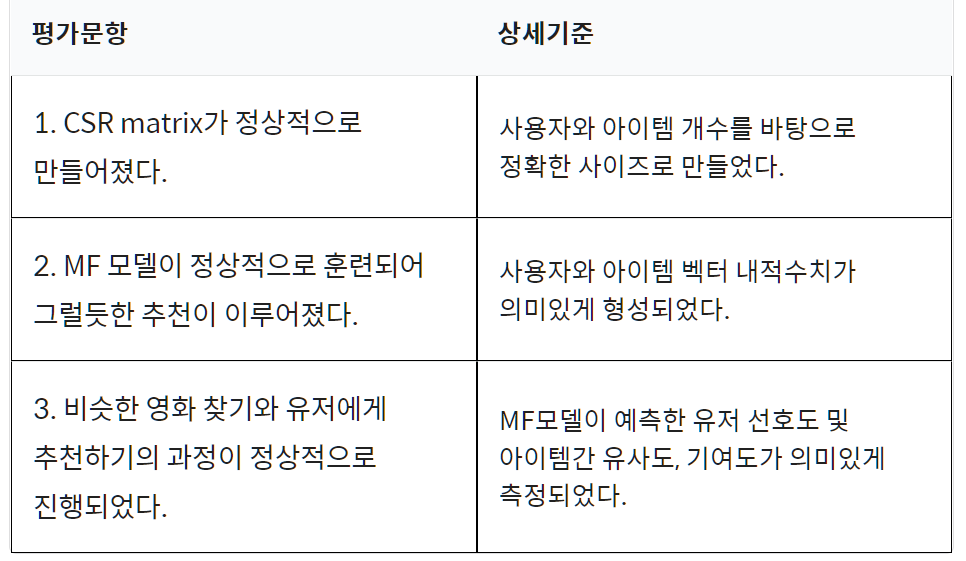